<a href="https://colab.research.google.com/github/irawan09/Baldness_Detection/blob/master/Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing the openCV library

**Install the openCV library**

In [ ]:
!pip install opencv-python

# Importing Necessary library

**Install, import and check version the Tensorlow library**

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

print("Tensor flow version : "+ str(tf.__version__))

Tensor flow version : 2.3.0


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

**Import Keras Library**

In [ ]:
from sklearn.metrics import f1_score

from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

from keras.applications.inception_v3 import InceptionV3, preprocess_input

# Image Data Preparation (celebA dataset)

**Download the data from server.**

In [ ]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

--2020-10-16 15:21:38--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.64
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  20.0MB/s    in 70s     

2020-10-16 15:22:48 (19.7 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



**Extract CelebA data that you downloaded from server**

In [ ]:
import zipfile

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

# Data Exploring

**Check the number of Image Data**

In [ ]:
import os
import cv2

root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print("number of datasets : ",len(img_list))

number of datasets :  202599


**Check the first Image data**

188578.jpg
----------------------------------------------------------------------------------------------------


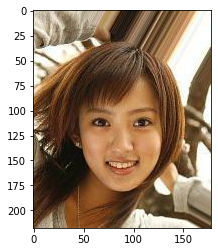

In [ ]:
for img in os.listdir(root):
    print(img)
    print('-'*100)
    img_array = load_img(os.path.join(root, img))
    plt.imshow(img_array, cmap="gray")
    plt.show()
    break

# Data Augmentation

**Create the Image Data Generator object**

In [ ]:
datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

**Load one image and reshape**

In [ ]:
for image in os.listdir(root):    
    image = load_img(os.path.join(root, image))
    x = img_to_array(image)/255.
    x = x.reshape((1,) + x.shape)
    break


**Plot 10 augmented images of the loaded image**

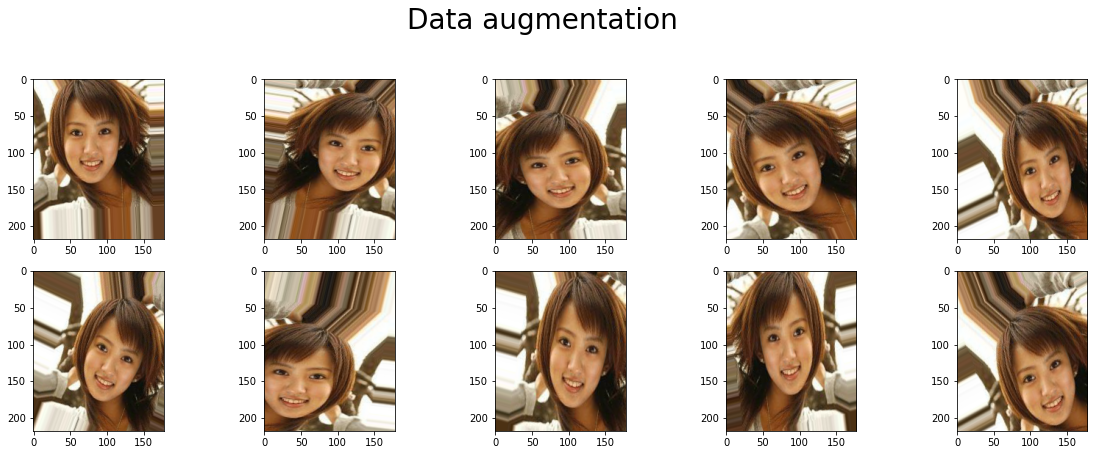

In [ ]:
plt.figure(figsize=(20,10))
plt.suptitle("Data augmentation", fontsize=28)

i = 0


for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3,5,i+1)
    plt.grid(False)
    plt.imshow(batch.reshape(218,178, 3))
    
    if i==9:
        break
    i = i+1
    
plt.show()

# Processing the label data

**Read the list of attribute data in csv file**

In [ ]:
import requests
import io

url_attributes = 'https://raw.githubusercontent.com/irawan09/Baldness_Detection/master/list_attr_celeba.csv'

download_attributes = requests.get(url_attributes).content
df_attr = pd.read_csv(io.StringIO(download_attributes.decode('utf-8')))
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True)

print("There are : "+str(df_attr.columns.size)+" labels")

There are : 40 labels


**List of available attributes**

In [ ]:
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


**Check the list of attribute data**

In [ ]:
df_attr.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1


**Plot the Young and Old People data**

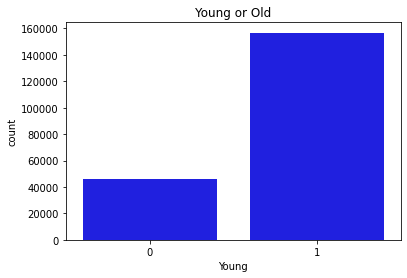

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.title('Young or Old')
sns.countplot(x='Young', data=df_attr, color="blue")
plt.show()

# Splitting the data


**Read the splitting data file as csv file**

In [ ]:
url_partition = 'https://raw.githubusercontent.com/irawan09/Baldness_Detection/master/list_eval_partition.csv'
download_partition = requests.get(url_partition).content

df_partition = pd.read_csv(io.StringIO(download_partition.decode('utf-8')))
df_partition.sample(5)

,image_id,partition
104980,104981.jpg,0
117586,117587.jpg,0
59639,059640.jpg,0
40136,040137.jpg,0
85394,085395.jpg,0


**Partition data exploring**

*   0 -> train data
*   1 -> validation data
*   2 -> test data

In [ ]:
df_partition["partition"].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

**join the partition data with the attributes data**

In [ ]:
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Young'], how='inner')
df_par_attr.head()

,partition,Young
image_id,,
000001.jpg,0,1
000002.jpg,0,1
000003.jpg,0,1
000004.jpg,0,1
000005.jpg,0,1


# Create Necessary Function to generate the data frame

**Create load reshape image function**

In [ ]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x

**Create function to generate the dataframe**

In [ ]:
def generate_df(partition, attr, num_samples):
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(root +"/"+ fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(root+"/"+ index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

# Generate Data Training and Data Validation

**Generate Data Training**

In [ ]:
TRAINING_SAMPLES = 10000
BATCH_SIZE = 16

# Train data
x_train, y_train = generate_df(0, 'Young', TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [ ]:
VALIDATION_SAMPLES = 2000

# Validation Data
x_valid, y_valid = generate_df(1, 'Young', VALIDATION_SAMPLES)

# Validation - Data Preparation - Data Augmentation with generators
valid_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
)

valid_datagen.fit(x_valid)

validation_generator = valid_datagen.flow(
x_valid, y_valid,
)

# Build the Model (Transfer Learning Model)

In [ ]:
# give the model a name, used to save arrays and results and keep tracks of your research
# Import InceptionV3 Model
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 20

inc_model = "mobilenet_20k_v1.0"

# load model without its output layers
inc_model = InceptionV3(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights='imagenet')
print("number of layers:", len(inc_model.layers))

87916544/87910968 [==============================] - 1s 0us/step
number of layers: 311


In [ ]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [ ]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

In [ ]:
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5', 
                               verbose=1, save_best_only=True)

In [ ]:
hist = model_.fit_generator(train_generator
                     , validation_data = validation_generator
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
625/625 [==============================] - ETA: 0s - loss: 0.7031 - accuracy: 0.5442
Epoch 00001: val_loss improved from inf to 0.63847, saving model to weights.best.inc.male.hdf5
625/625 [==============================] - 107s 171ms/step - loss: 0.7031 - accuracy: 0.5442 - val_loss: 0.6385 - val_accuracy: 0.6435
Epoch 2/20
625/625 [==============================] - ETA: 0s - loss: 0.6530 - accuracy: 0.6202
Epoch 00002: val_loss improved from 0.63847 to 0.58196, saving model to weights.best.inc.male.hdf5
625/625 [==============================] - 106s 170ms/step - loss: 0.6530 - accuracy: 0.6202 - val_loss: 0.5820 - val_accuracy: 0.6850
Epoch 3/20
625/625 [==============================] - ETA: 0s - loss: 0.6053 - accuracy: 0.6732
Epoch 00003: val_loss improved from 0.58196 to 0.54838, saving model to weights.best.inc.male.hdf5
625/625 [==============================] - 106s 170ms/step - loss: 0.6053

# Model Evaluation

**Make a graph based on loss function and loss data**

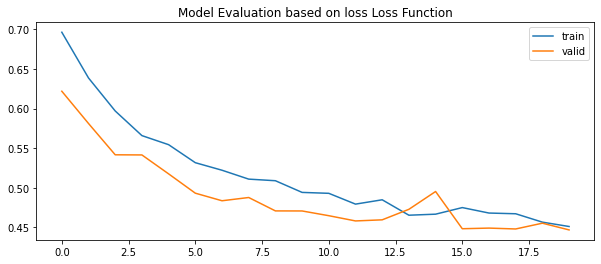

In [ ]:
# Plot loss through epochs
plt.figure(figsize=(10, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Model Evaluation based on loss Loss Function')
plt.show()


In [ ]:
#load the best model
model_.load_weights('weights.best.inc.male.hdf5')

In [ ]:
# Test Data
TEST_SAMPLES = 2000

x_test, y_test = generate_df(2, 'Bald', TEST_SAMPLES)

# generate prediction
model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

Model Evaluation
Test accuracy: 52.8000%
f1_score: 0.26479750778816197
